<a href="https://colab.research.google.com/github/elybatista/Data_Science/blob/master/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Nesta análise, irei abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como operadoras de cartão de crédito, bancos e *fintechs*. 

<p align=center>
<img src="https://veja.abril.com.br/wp-content/uploads/2016/05/alx_70705789_thumbnail_original.jpeg?quality=70&strip=info&resize=680,453" width="50%"></p>

O cartão de crédito detém a maior parte das transações financeiras de dinheiro. Com o crescimento cada vez mais das compras online, o uso do cartão de crédito é muito mais frequente. Mas as fraudes envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que a pessoa tenta fazer uma compra e tem seu cartão bloqueado preventivamente - o que gera estresse e constrangimento.

As empresas tem investido em tecnologia a cada ano para evitar e reduzir esse tipo de ocorrência e o uso de modelos de machine learning tem se mostrado uma ferramenta poderosa para detecção defraudes.

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.



## Importando os Dados

Os dados usados neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. O objetivo é encontrar um meio de condensar a informação contida em várias variáveis originais em um conjunto menor de variáveis estatísticas (componentes) com uma perda mínima de informação.

Esses componentes são em número menor or igual às variáveis originais, vai depender do quanto se reduz e quanto mais se reduz, mais se perde de informação. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [1]:
# Instalação de biblioteca
!pip install scikit-plot

In [2]:
# importando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# Ocultando os avisos de Warnings
import warnings
warnings.filterwarnings('ignore')

# Configurando o estilo dos gráficos com o Seaborn
sns.set_style('dark')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Importando dados

In [3]:
# importar os dados para um dataframe
df = pd.read_csv('https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1')

Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

## Análise Exploratória

Vamos abordar agora alguns tópicos, como:

* Ver as 5 primeiras entradas
* Ver o resumo estatístico do dataframe
* Verificar se há valores ausentes
* Plotar uma matriz de confusão
* Plotar um `boxplot` para a variável `Amount`.


In [4]:
# Vamos ver as primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Abaixo verificamos o resumo estatístico por meio do método describe()
e podemos ver que as principais variáveis transformadas pelo PCA não apresentam
nenhuma discrepância aparentemente.

In [5]:
# Ver resumo estatístico
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Podemos ver que na variável Amount (quantia), o valor médio das transações é de 88.34, 
a mediana igual a 22.00 e o desvio padrão de 250.12, atingindo o valor máximo de 25691.16 e 75%  das trasações financeiras é composta em sua maioria de quantias menores, chegando no máximo a 77.16.

O dataset não apresentou nenhum valor ausente ou que precisasse de uma etapa de limpeza.
No comando abaixo, o maior valor da coluna para valores nulos é zero, o que confirma que não
há valores ausentes.

In [6]:
# Ver se há valores ausentes
df.isnull().sum().max()

0

Como informado no início, as entradas relativas à transaçõs fraudulentas correspondem a 0,17% do total.

O gráfico de barras mostrado abaixo mostra como essa discrepância se torna nítida. Na prática, isso interfere no desempenho do modelo e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

Transações: (0-Normal / 1-Fraudulenta)
0    284315
1       492
Name: Class, dtype: int64

As fraudes representam 0.1727% do dataset.


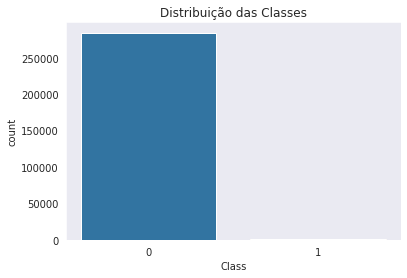

In [7]:
# Ver o balanceamento das classes
print('Transações: (0-Normal / 1-Fraudulenta)')
print(df.Class.value_counts())
print("\nAs fraudes representam {:.4f}% do dataset.".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# Plotar gráfico de barras para as classes
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot();

Sem fazer ajustes, vamos treinar o modelo e fazer a previsão em cima do conjunto de teste desbalanceado. Vamos plotar também a matriz de confusão e o relatório de classificação para ver o modelo aplicado em uma base não balanceada.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9994    0.9995    0.9995     71080
           1     0.7117    0.6475    0.6781       122

    accuracy                         0.9989     71202
   macro avg     0.8556    0.8235    0.8388     71202
weighted avg     0.9989    0.9989    0.9989     71202

Acurácia: 0.9989.
AUC: 0.8235.


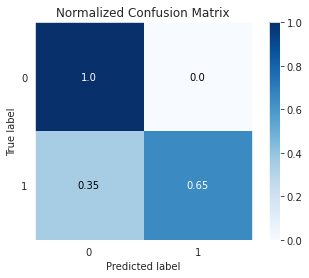

In [8]:
# Separa as variáveis entre X e y
X = df.drop('Class', axis=1)
y = df['Class']

# Dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instancia e treina um modelo de Regressão Logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Plotar
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# Imprimir relatório de classificação
print('Relatório de Classificação:\n', classification_report(y_test, y_pred, digits=4))

# Imprimir a acurácia do modelo
print('Acurácia: {:.4f}.'.format(accuracy_score(y_test, y_pred)))

# Imprimir a área sob a curva - AUC
print('AUC: {:.4f}.'.format(roc_auc_score(y_test, y_pred)))

Vemos nas informações acima que conseguimos uma acurácia de 99% no nosso modelo, isso é um bom resultado, mas o problema é que no caso de dados desbalanceados, a acurácia não representa uma métrica válida. 

Podemos identificar na matriz de confuzão que a identificação de operações fraudulentas é baixa, mais o pior são as operações fraudulentas que não são identificadas como tal. Isso é um problema para uma instituição financeira.

Por ter uma quantidade muito maior de transações não fraudulentas, o modelo é muito bom em detectar esse tipo de operação, mas nosso objetivo é analisar as operações fraudulentas e para não ocorrer o overfitting, que é o caso acima, temos que buscar um equilíbrio nos dados.

Acima podemos ver também o valor da medida de Area Under Curve (AUC), que avalia a classificação de modelos de classificação binários. O valor do AUC varia de 0,0 até 1,0. Um modelo em que as previsões estão 100% erradas tem uma AUC de 0, equanto um modelo cuja as previsões estão 100% corretas tem uma AUC de 1. Nessa análise com os dados desbalanceados, obtemos uma AUC de 0.80. 

Então, vamos continuar nossa análise e fazer o balanceamento.

Continuando com a análise exploratória, plotamos os boxplots para ver se há alguma diferença no padrão das transações em relação a variável `Amount`.

Podemos perceber que as distribuições são diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de machine learning.

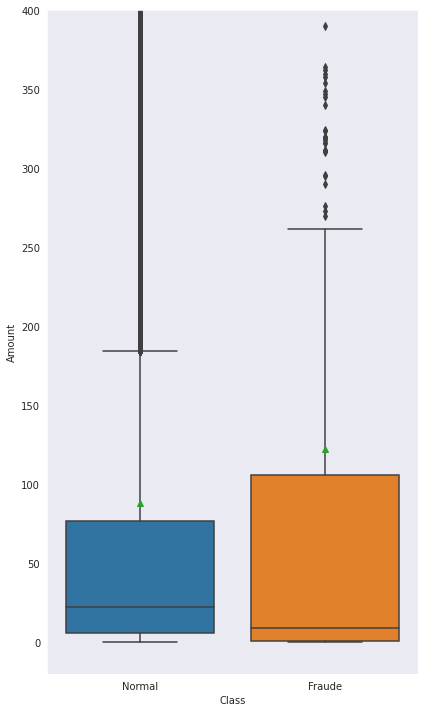

In [9]:
# Plotando boxplot das variáveis Class e Amount
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0,1], ['Normal', 'Fraude'])

plt.tight_layout()

Olhando as informações estatísticas para os dados de Transação fraudulenta (df.Class == 1), podemos ver que a sua média está em 122.21 e a mediana em 9.25.

In [10]:
df[df.Class==1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Já as transações normais, temos a média em 88.29 e a mediana em 22.00.

In [11]:
df[df.Class==0]['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Podemos observar resumidamente nessa etapa exploratória que:

* O dataset está muito desbalanceado, já que as transações fraudulentas são apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no dataset.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as variáveis originais foram padronizadas.
* As colunas Time e Amount não estão normalizadas.

## Preparação dos Dados

Para alimentar o modelo de Regressão Logística, precisamos preparar os dados, então iremos:

* Padronizar os dados que ainda não haviam sido pré-processados, como `Time` e `Amount`, que estão em outra ordem de grandeza.
* Dividir o conjunto de dados entre treino e teste.
* Balancear o conjunto de dados para não ocorrer o overfitting da classe 1.

Padronizando `Time` e `Amount`

A padronização será feita por meio da classe StandardScaler. Isso significa que para cada feature, a média seria 0, e o desvio padrão seria 1. Desta forma as features ficam mais manejáveis para o nosso modelo.

In [12]:
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time','Amount'], axis=1, inplace=True)

# Vendo as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


#### Divisão dos dados em treino e teste

Antes de fazer o balanceamento dos dados, devemos separar os dados existentes entre treino e teste.
Para garantir que os dados de treino e teste tenham a mesma quantidade proporcional de classes, usamos o parâmetro stratify=y

In [13]:
# Separa os dados de classe do resto do dataset entre as variáveis X e y.
X = df_clean.drop('Class', axis=1)
y = df['Class']

# Divide o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

#### Balanceamento dos dados

Com a biblioteca `imblearn` podemos aplicar facilmente técnicas de balanceamento de dados e para preservar a classe minoritária, utilizamos a opção under_sampling.

Balanceamento das classe 1 e 0
1    369
0    369
dtype: int64


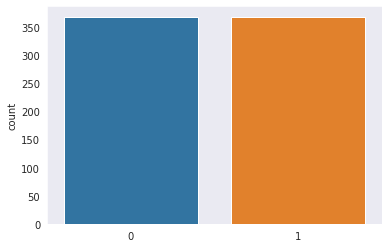

In [14]:
# Usando a técnica de under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# Ver o balanceamento das classes
print('Balanceamento das classe 1 e 0')
print(pd.Series(y_rus).value_counts())

# Plota a nova distribuição das classes
sns.countplot(y_rus)

Agora podemos ver que não existe mais aquela discrepância entre as classes como mostrado no início da análise.

Com os dados balanceados, vamos ver a comparação da matriz de correlação para identificar quais variáveis estão mais fortemente relacionadas entre si.

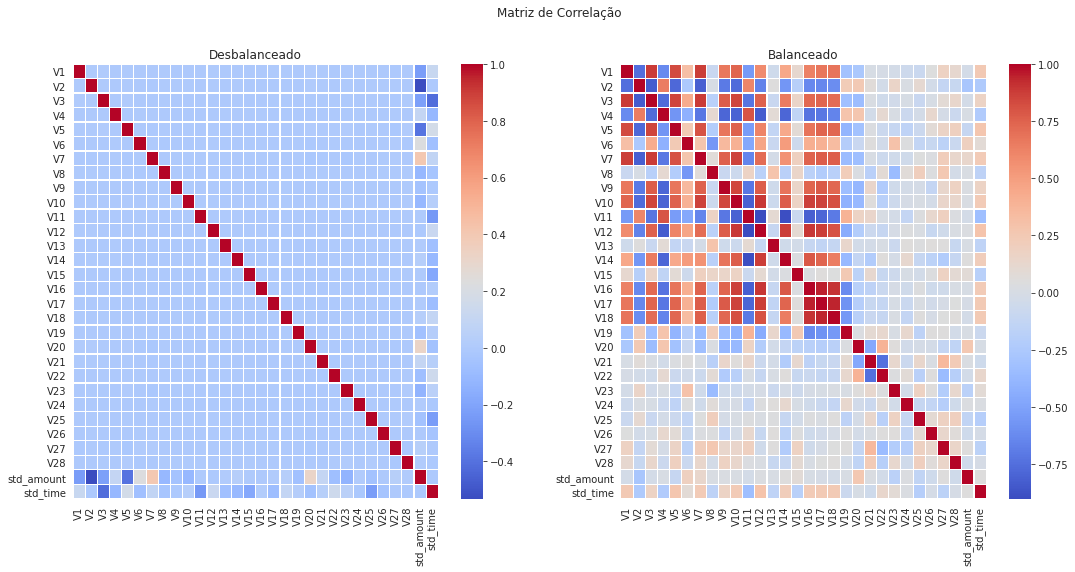

In [15]:
# Plotar a matriz de correlação
corr1 = X_train.corr()
corr2 = pd.DataFrame(X_rus).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr1, xticklabels=corr1.columns, yticklabels=corr1.columns, linewidths=.1, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr2, xticklabels=corr1.columns, yticklabels=corr1.columns, linewidths=.1, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

Podemos ver nas imagens da matriz de correlação acima, a diferença entre os dados balanceados e desbalanceados. Observe que com o balanceamento temos muito mais informações.

## Modelo de Machine Learning

Após a preparação dos dados e a análise exploratória, vamos construir um modelo para **classificação** usando **Regressão Logística**.

A Regressão Logística é um recurso que nos permite estimar a probabilidade associada à ocorrência de determinado evento em face de um conjunto de variáveis explanatórias.

Então, depois de instanciar o modelo, vamos treiná-lo com os dados em `X_rus` e `y_rus`. Depois vamos realizar as previsões nos dados de teste.

In [16]:
# Instanciando e treinando um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# Fazendo previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

## Avaliar o desempenho do modelo

Agora que temos o modelo treinado e as previsões feitas, vamos partir para a avaliação do desempenho.

Vimos que a acurácia não é uma métrica adequada para problemas com dados desbalanceados. Mas agora vamos avaliar os resultados com os dados balanceados.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9689    0.9842     71079
           1     0.0499    0.9431    0.0948       123

    accuracy                         0.9689     71202
   macro avg     0.5249    0.9560    0.5395     71202
weighted avg     0.9983    0.9689    0.9826     71202

Acurácia: 0.9689.
AUC: 0.9560.


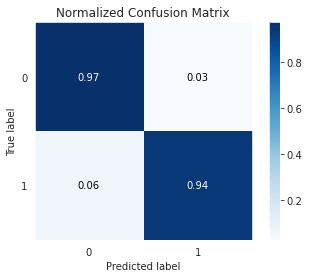

In [17]:
# Plotar a matiz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# Imprimir relatório de classificação
print('Relatório de Classificação:\n', classification_report(y_test, y_pred, digits=4))

# Imprimir a acurácia do modelo
print('Acurácia: {:.4f}.'.format(accuracy_score(y_test, y_pred)))

# Imprimir a área sob a curva - AUC
print('AUC: {:.4f}.'.format(roc_auc_score(y_test, y_pred)))

Agora podemos ver na matriz de confusão que o desempenho do modelo aumentou para identificar operações fraudulentas.

## Conclusão

Nessa análise podemos retirar alguns insights que nos ajudam em uma melhor tomada de decisão e até melhorar o modelo, são eles:

* A transformação dos dados pode atrapalhar, pois os dados sem muitas informações, informando o que cada coluna representa, pode interferir na construção do modelo, pois algumas dessas colunas podem adicionar informações inportantes para criação do modelo.
* Dados desbalanceados atrapalham com a eficácia do modelo, fazendo com que ele fique altamente enviesado.
* Dados balanceados fazem a acurácia do modelo serem parecidos quanto a prever falsos negativos. Porém a Regressão Logística é superior em prever falsos positivos.

Esse tipo de fraude prejudica muito a empresa, por isso, o processo de melhoria do modelo deve ser constante.